In [8]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

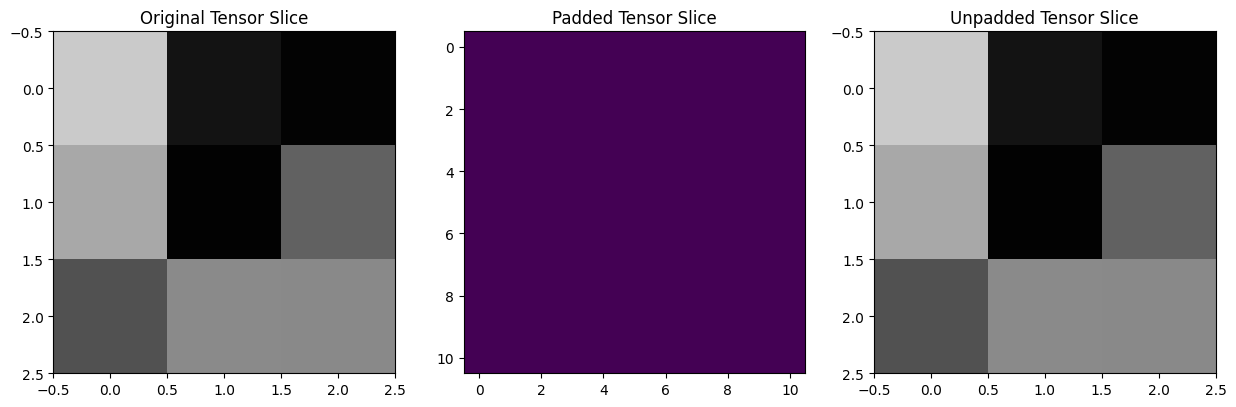

In [13]:
# Initialize x
x = torch.rand(1, 1, 3, 3, 3)

# Initialize the padding
padding = 4
p3d = (padding, padding, padding, padding, padding, padding)

# Pad the tensor
x_padded = F.pad(x, p3d)

# Now let's remove the padding
x_unpadded = x_padded[..., padding:-padding, padding:-padding, padding:-padding]

# Plot
fig, axs = plt.subplots(1, 3, figsize=(15,5))

# Original tensor
axs[0].imshow(x[0, 0, :, :, 0], cmap='gray', vmin=0, vmax=1)
axs[0].set_title('Original Tensor Slice')

# Padded tensor
axs[1].imshow(x_padded[0, 0, :, :, 0], cmap='gray')
axs[1].set_title('Padded Tensor Slice')

# Unpadded tensor
axs[2].imshow(x_unpadded[0, 0, :, :, 0], cmap='gray', vmin=0, vmax=1)
axs[2].set_title('Unpadded Tensor Slice')

plt.show()
#




        



###DEBUG NORMALIZATION

In [2]:
import torch.nn.functional as F
from utilities import *
from timeit import default_timer
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

/home/smrserraoseabr/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch
from torch.utils.data import DataLoader, TensorDataset

class PointGaussianNormalizer(object):
    def __init__(self, dataloader, is_label=False, eps=0.00001):
        super(PointGaussianNormalizer, self).__init__()
        self.eps = eps
        self.mean, self.std = self.batch_mean_and_sd(dataloader, is_label)

    def batch_mean_and_sd(self, loader, is_label):
        cnt = 0
        fst_moment = None
        snd_moment = None

        for data, labels in loader:
            data = labels if is_label else data  # if this is label normalizer, normalize labels
            data_shape = data.shape[-1]
            if fst_moment is None:
                fst_moment = torch.zeros(data_shape)
                snd_moment = torch.zeros(data_shape)

            b, t, h, w, c = data.shape
            nb_pixels = b * t * h * w
            sum_ = torch.sum(data, dim=[0, 1, 2, 3])
            sum_of_square = torch.sum(data ** 2, dim=[0, 1, 2, 3])
            fst_moment += sum_
            snd_moment += sum_of_square
            cnt += nb_pixels

        fst_moment /= cnt
        snd_moment /= cnt

        return fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)

    def encode(self, x):
        return (x - self.mean) / (self.std + self.eps)

    def decode(self, x):
        return x * (self.std + self.eps) + self.mean

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()


In [4]:
# Generate some sample data
data = torch.randn(100, 61, 32, 32, 6)*2000
labels = torch.randn(100, 61, 32, 32, 1)*3000

# Create dataloader

dataset = TensorDataset(data, labels)
subset = torch.utils.data.Subset(dataset, range(0, 100))
dataloader = DataLoader(dataset, batch_size=10)

# Create normalizers
input_normalizer = PointGaussianNormalizer(dataloader, is_label=False)
label_normalizer = PointGaussianNormalizer(dataloader, is_label=True)

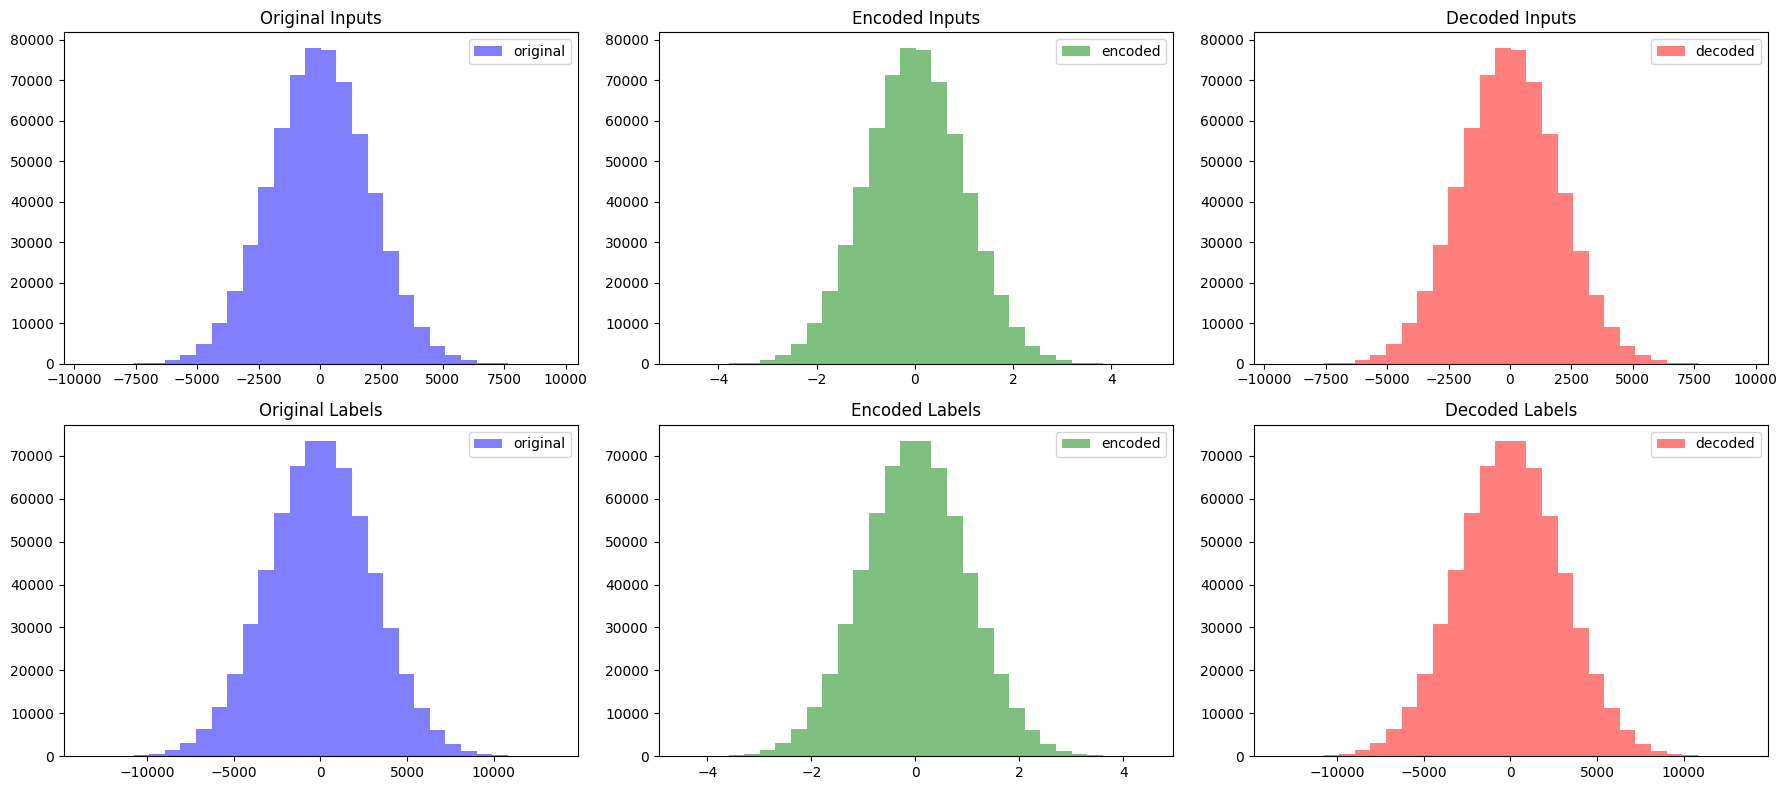

In [5]:
import matplotlib.pyplot as plt

# Pick the first batch of data
inputs, labels = next(iter(dataloader))

# Normalize inputs and labels
normalized_inputs = input_normalizer.encode(inputs)
normalized_labels = label_normalizer.encode(labels)

# Decode the normalized inputs and labels
decoded_inputs = input_normalizer.decode(normalized_inputs)
decoded_labels = label_normalizer.decode(normalized_labels)

# Pick a feature index to plot (any integer from 0 to 5 for your case)
feature_idx = 0

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))

# Plot original inputs
axes[0, 0].hist(inputs[..., feature_idx].flatten().cpu().numpy(), bins=30, alpha=0.5, color='b', label='original')
axes[0, 0].set_title('Original Inputs')

# Plot encoded inputs
axes[0, 1].hist(normalized_inputs[..., feature_idx].flatten().cpu().numpy(), bins=30, alpha=0.5, color='g', label='encoded')
axes[0, 1].set_title('Encoded Inputs')

# Plot decoded inputs
axes[0, 2].hist(decoded_inputs[..., feature_idx].flatten().cpu().numpy(), bins=30, alpha=0.5, color='r', label='decoded')
axes[0, 2].set_title('Decoded Inputs')

# Plot original labels
axes[1, 0].hist(labels.flatten().cpu().numpy(), bins=30, alpha=0.5, color='b', label='original')
axes[1, 0].set_title('Original Labels')

# Plot encoded labels
axes[1, 1].hist(normalized_labels.flatten().cpu().numpy(), bins=30, alpha=0.5, color='g', label='encoded')
axes[1, 1].set_title('Encoded Labels')

# Plot decoded labels
axes[1, 2].hist(decoded_labels.flatten().cpu().numpy(), bins=30, alpha=0.5, color='r', label='decoded')
axes[1, 2].set_title('Decoded Labels')

for ax_row in axes:
    for ax in ax_row:
        ax.legend()

plt.tight_layout()
plt.show()


In [3]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, IterableDataset, TensorDataset
import os
import xarray as xr

import scipy.io
import h5py


import operator
from functools import reduce
from functools import partial



/home/smrserraoseabr/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# normalization, pointwise gaussian
class PointGaussianNormalizer(object):
    def __init__(self, dataloader, is_label=False, eps=0.00001):
        super(PointGaussianNormalizer, self).__init__()
        self.eps = eps
        self.mean, self.std = self.batch_mean_and_sd(dataloader, is_label)

    def batch_mean_and_sd(self, loader, is_label):
        cnt = 0
        fst_moment = None
        snd_moment = None

        for data, labels in loader:
            data = labels if is_label else data  # if this is label normalizer, normalize labels
            data_shape = data.shape[-1]
            if fst_moment is None:
                fst_moment = torch.zeros(data_shape)
                snd_moment = torch.zeros(data_shape)

            b, t, h, w, c = data.shape
            nb_pixels = b * t * h * w
            sum_ = torch.sum(data, dim=[0, 1, 2, 3])
            sum_of_square = torch.sum(data ** 2, dim=[0, 1, 2, 3])
            fst_moment += sum_
            snd_moment += sum_of_square
            cnt += nb_pixels

        fst_moment /= cnt
        snd_moment /= cnt

        return fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)

    def encode(self, x):
        return (x - self.mean) / (self.std + self.eps)

    def decode(self, x):
        return x * (self.std + self.eps) + self.mean

    def cuda(self, device):
        self.mean = self.mean.to(device)
        self.std = self.std.to(device)
        return self 


In [7]:
class ReadXarrayDataset(Dataset):
    def __init__(self, folder, input_vars, output_vars, num_files=None):
        self.folder = folder        
        self.file_list = os.listdir(folder)[:num_files] if num_files else os.listdir(folder)            
        self.input_vars = input_vars.copy()
        self.input_vars.append('x_encoding')
        self.input_vars.append('y_encoding')
        self.input_vars.append('time_encoding')
        self.output_vars = output_vars.copy()

        # self.input_normalizers = []
        # self.output_normalizers = []
        # self.file_stats = {}



    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = os.path.join(self.folder, self.file_list[idx])
        data = xr.open_dataset(file_path)

        X = data['X'].values
        Y = data['Y'].values
        TIME = data['time'].values

        x_mesh, y_mesh = np.meshgrid(data.X, data.Y, indexing='ij')
        TIME_MESH = np.meshgrid(data.time, data.X, data.Y, indexing='ij')
        data = data.assign(x_encoding=xr.DataArray(x_mesh, coords=[("X", X), ("Y", Y)]))
        data = data.assign(y_encoding=xr.DataArray(y_mesh, coords=[("X", X), ("Y", Y)]))
        data = data.assign(time_encoding=xr.DataArray(TIME_MESH[0], coords=[("time", TIME), ("X", X), ("Y", Y)]))
        
        input_data = []
        for var in self.input_vars:
            if 'time' in data[var].dims and 'X' in data[var].dims and 'Y' in data[var].dims:
                input_data.append(torch.tensor(data[var].values, dtype=torch.float32))
            elif 'X' in data[var].dims and 'Y' in data[var].dims:
                scalar_matrix = torch.tensor(data[var].values, dtype=torch.float32) 
                scalar_matrix = scalar_matrix.unsqueeze(0).expand(data.time.size, -1, -1)
                input_data.append(scalar_matrix)
            elif 'time' in data[var].dims:
                scalar_matrix = torch.tensor(data[var][0].values, dtype=torch.float32) 
                scalar_matrix = scalar_matrix.unsqueeze(-1).unsqueeze(-1).expand(-1, data.X.size, data.Y.size)
                input_data.append(scalar_matrix)
                
        #print(len(input_data))

        output_data = []
        for var in self.output_vars:
           output_data.append(torch.tensor(data[var].values, dtype=torch.float32))

        #print(output_data)


        input_data = torch.stack(input_data, dim=-1)
        output_data = torch.stack(output_data, dim=-1)
    
        return input_data, output_data  


In [12]:
#create a variable called resolution 
resolution = 32
folder = "/scratch/smrserraoseabr/Projects/FluvialCO2/results" + str(resolution) + "/"
input_vars = ['Por', 'Perm', 'gas_rate'] # Porosity, Permeability, ,  Well 'gas_rate', Pressure + x, y, time encodings 
output_vars = ['CO_2'] 



num_files= 1000
traintest_split = 0.8

batch_size = 61

ntrain = num_files*traintest_split
ntest = num_files - ntrain

learning_rate = 0.001
epochs = 500 


iterations = epochs*(ntrain//batch_size)
modes = 12
width = 128 

# Prepare the path
path = 'ns_fourier_3d_N{}_ep{}_m{}_w{}'.format(ntrain, epochs, modes, width)

# Include in the path the input and output variables
path += '_INPUT_' + '_'.join(input_vars) + '_OUTPUT_' + '_'.join(output_vars)

# Create paths for log, model, and images
path_log = os.path.join('runs', path, 'log')
# Modify here: 'model.pt' will be the filename, not a subdirectory
path_model = os.path.join('runs', path, 'model.pt') 
path_image = os.path.join('runs', path, 'images')

# Create directories
os.makedirs(path_log, exist_ok=True)
os.makedirs(os.path.dirname(path_model), exist_ok=True)  # Get the directory of the path_model
os.makedirs(path_image, exist_ok=True)

# Create paths for train error and test error files
path_train_err = os.path.join(path_log, 'train.txt')
path_test_err = os.path.join(path_log, 'test.txt')



S = 32
#T_in = 61
T = 61

device = 'cuda' if torch.cuda.is_available() else 'cpu'

#device = 'cpu'
print('Using ' + device + ' for training')

################################################################
# load data
################################################################



# Create instance of ReadXarrayDatasetNorm class for training data
dataset = ReadXarrayDataset(folder=folder, input_vars=input_vars, output_vars=output_vars, num_files = num_files)

train_size = int(traintest_split * len(dataset))
test_size = len(dataset) - train_size

train_dataset = torch.utils.data.Subset(dataset, range(0, train_size))
test_dataset = torch.utils.data.Subset(dataset, range(train_size, train_size + test_size))


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# We no longer have the entire dataset loaded into memory. The normalization is handled by the Dataset class.
# We also can't directly print the shape of the data because it's not all loaded into memory.



# Normalize input_data and output_data
# Create normalizers for training data
train_input_normalizer = PointGaussianNormalizer(train_loader, is_label=False)
train_output_normalizer = PointGaussianNormalizer(train_loader, is_label=True)

# Create normalizers for test data
test_input_normalizer = PointGaussianNormalizer(test_loader, is_label=False)
test_output_normalizer = PointGaussianNormalizer(test_loader, is_label=True)

train_input_normalizer = train_input_normalizer.cuda(device)
train_output_normalizer = train_output_normalizer.cuda(device)

test_input_normalizer = test_input_normalizer.cuda(device)
test_output_normalizer = test_output_normalizer.cuda(device)




Using cpu for training


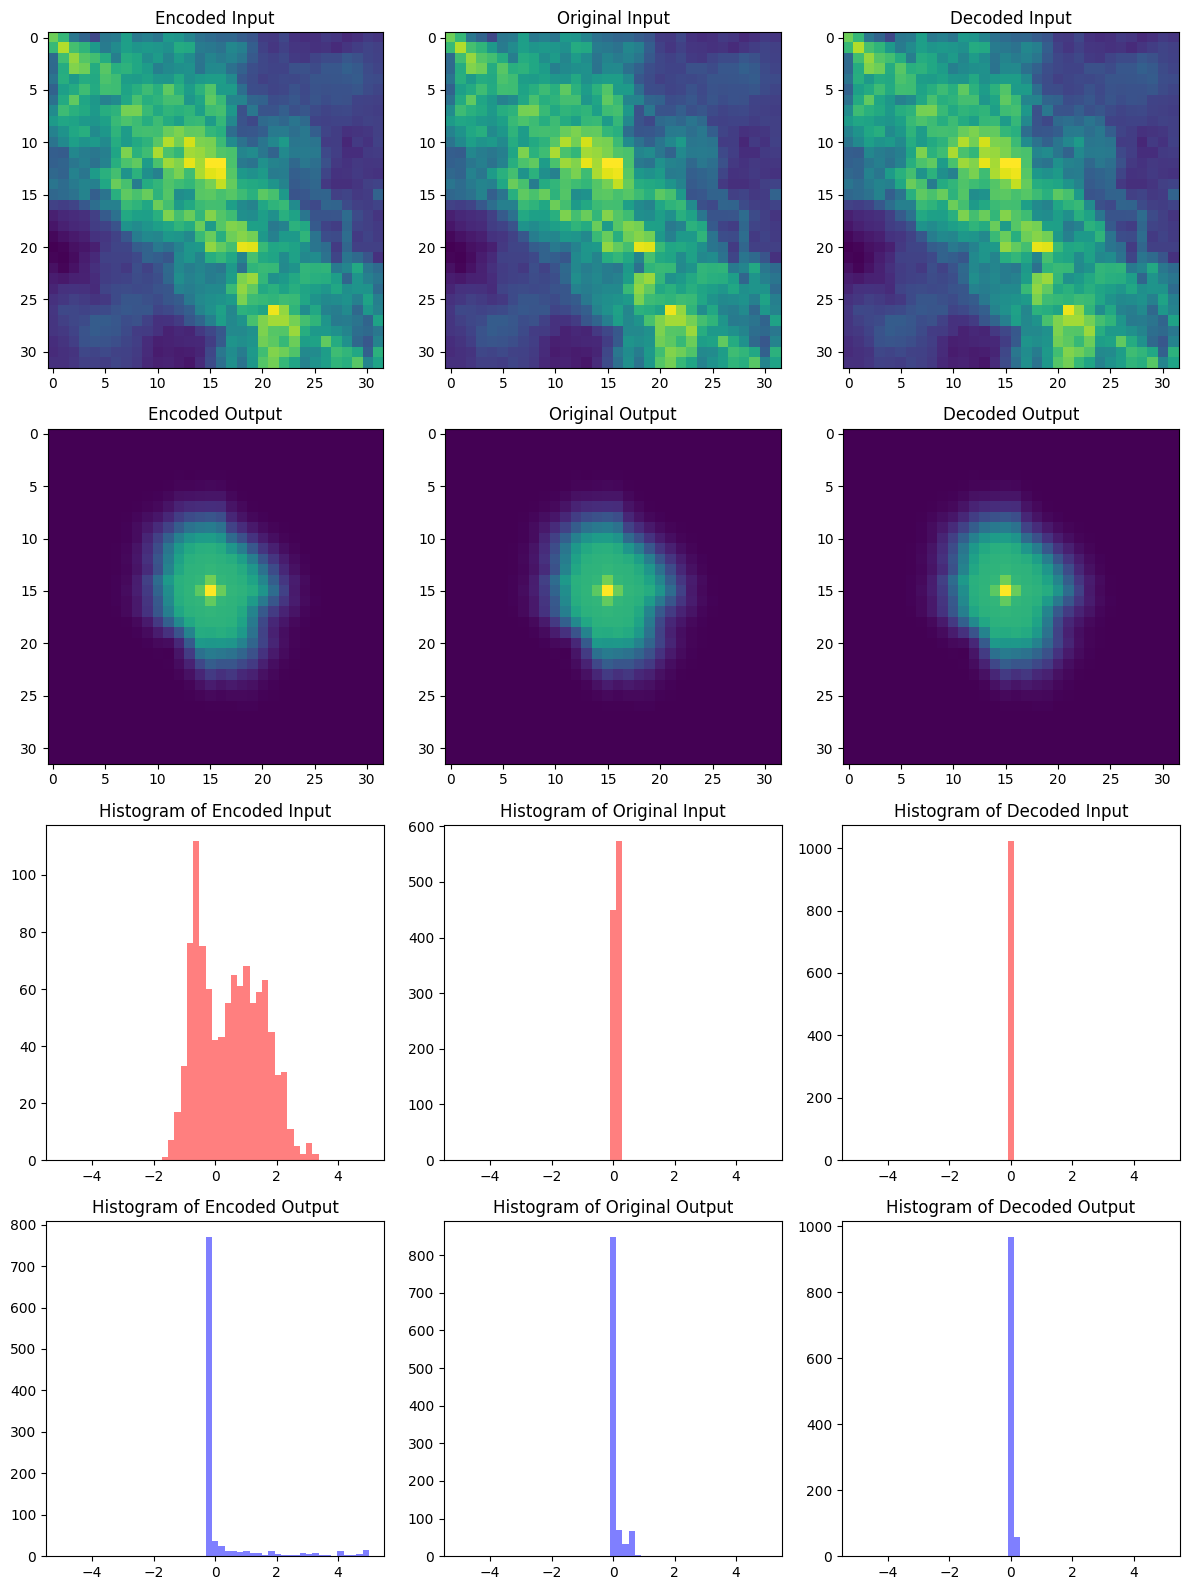

In [30]:
import numpy as np
import matplotlib.pyplot as plt

for index, (x, y) in enumerate(test_loader):
    x = x.to(device)
    y = y.to(device)

    x_encoded = test_input_normalizer.encode(x)
    y_encoded = test_output_normalizer.encode(y)
    y_decoded = test_output_normalizer.decode(y)
    x_decoded = test_input_normalizer.decode(x)

    if index == 0:
        fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(12, 16)) # Adjusted the number of rows

        # Plot images
        ax[0, 0].imshow(x_encoded[0, -1, :, :, 0].T)
        ax[0, 0].set_title('Encoded Input')

        ax[0, 1].imshow(x[0, -1, :, :, 0].T)
        ax[0, 1].set_title('Original Input')

        ax[0, 2].imshow(x_decoded[0, -1, :, :, 0].T)
        ax[0, 2].set_title('Decoded Input')

        ax[1, 0].imshow(y_encoded[0, -1, :, :, 0].T)
        ax[1, 0].set_title('Encoded Output')

        ax[1, 1].imshow(y[0, -1, :, :, 0].T)
        ax[1, 1].set_title('Original Output')

        ax[1, 2].imshow(y_decoded[0, -1, :, :, 0].T)
        ax[1, 2].set_title('Decoded Output')


        bins = np.linspace(-5, 5, 50)

        # Plot histograms
        ax[2, 0].hist(x_encoded[0, -1, :, :, 0].flatten(), bins=bins, alpha=0.5, color='red')
        ax[2, 0].set_title('Histogram of Encoded Input')

        ax[2, 1].hist(x[0, -1, :, :, 0].flatten(), bins=bins, alpha=0.5, color='red')
        ax[2, 1].set_title('Histogram of Original Input')

        ax[2, 2].hist(x_decoded[0, -1, :, :, 0].flatten(), bins=bins, alpha=0.5, color='red')
        ax[2, 2].set_title('Histogram of Decoded Input')

        ax[3, 0].hist(y_encoded[0, -1, :, :, 0].flatten(), bins=bins, alpha=0.5, color='blue')
        ax[3, 0].set_title('Histogram of Encoded Output')

        ax[3, 1].hist(y[0, -1, :, :, 0].flatten(), bins=bins, alpha=0.5, color='blue')
        ax[3, 1].set_title('Histogram of Original Output')

        ax[3, 2].hist(y_decoded[0, -1, :, :, 0].flatten(), bins=bins, alpha=0.5, color='blue')
        ax[3, 2].set_title('Histogram of Decoded Output')

        plt.tight_layout()
        plt.show()

        break


In [31]:
for index, (x, y) in enumerate(test_loader):
    x = x.to(device)
    y = y.to(device)

    # Assuming you have test_input_normalizer and test_output_normalizer objects

    # Encode the input and output data
    x_encoded = test_input_normalizer.encode(x)
    y_encoded = test_output_normalizer.encode(y)

    # Decode the input and output data
    y_decoded = test_output_normalizer.decode(y_encoded)
    x_decoded = test_input_normalizer.decode(x_encoded)

    # Compare the original and decoded data
    x_diff = torch.abs(x - x_decoded)
    y_diff = torch.abs(y - y_decoded)


    x_mae = torch.mean(x_diff)
    y_mae = torch.mean(y_diff)

    # Print the MAE values
    print("Input MAE:", x_mae.item())
    print("Output MAE:", y_mae.item())

    x_mse = torch.mean(x_diff**2)
    y_mse = torch.mean(y_diff**2)
    x_psnr = 10 * torch.log10(1.0 / x_mse)
    y_psnr = 10 * torch.log10(1.0 / y_mse)

    # Print the PSNR values - PSNR is the peak signal-to-noise ratio which is a measure of the quality of reconstruction
    print("Input PSNR:", x_psnr.item())
    print("Output PSNR:", y_psnr.item())


    # Define tolerance values
    x_tol = 1e-5  # Adjust the tolerance value as needed
    y_tol = 1e-5  # Adjust the tolerance value as needed

    # Check if the decoding is accurate
    if torch.allclose(x, x_decoded, atol=x_tol, rtol=0):
        print("Input decoding is accurate!")
    else:
        print("Input decoding is not accurate.")

    if torch.allclose(y, y_decoded, atol=y_tol, rtol=0):
        print("Output decoding is accurate!")
    else:
        print("Output decoding is not accurate.")


Input MAE: 8.54586687637493e-06
Output MAE: 9.095076913823164e-10
Input PSNR: 84.64024353027344
Output PSNR: 175.61241149902344
Input decoding is not accurate.
Output decoding is accurate!
Input MAE: 1.0293832019669935e-05
Output MAE: 9.259555344698356e-10
Input PSNR: 83.40782165527344
Output PSNR: 175.70372009277344
Input decoding is not accurate.
Output decoding is accurate!
Input MAE: 9.722602953843307e-06
Output MAE: 9.32735555458919e-10
Input PSNR: 84.55244445800781
Output PSNR: 175.90003967285156
Input decoding is not accurate.
Output decoding is accurate!
Input MAE: 8.435348718194291e-06
Output MAE: 8.873989876256871e-10
Input PSNR: 83.3505859375
Output PSNR: 175.440673828125
Input decoding is not accurate.
Output decoding is accurate!


Using cpu for training
preprocessing finished, time used: 0.009552496019750834
epoch 0 of 7
0
1


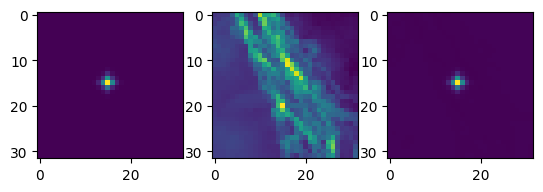

epoch 1 of 7
0
1


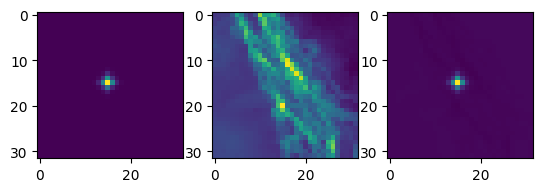

epoch 2 of 7
0
1


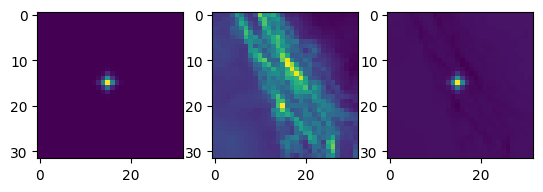

epoch 3 of 7
0
1


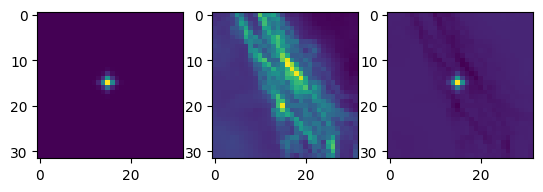

epoch 4 of 7
0
1


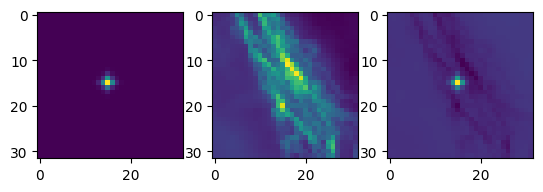

epoch 5 of 7
0
1


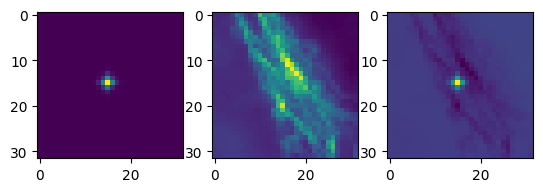

epoch 6 of 7
0
1


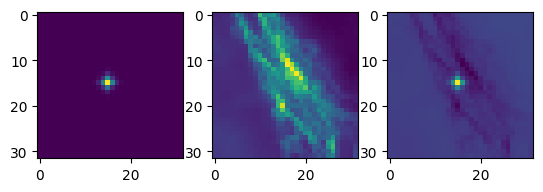

In [39]:
import torch.nn.functional as F
from utilities import *
from timeit import default_timer
import matplotlib.pyplot as plt
import numpy as np
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, IterableDataset, TensorDataset
import os
import xarray as xr

import scipy.io
import h5py


import operator
from functools import reduce
from functools import partial

#################################################
#
# Custom Dataset Class
#
#################################################

class ReadXarrayDataset(Dataset):
    def __init__(self, folder, input_vars, output_vars, num_files=None):
        self.folder = folder        
        self.file_list = os.listdir(folder)[:num_files] if num_files else os.listdir(folder)            
        self.input_vars = input_vars.copy()
        self.input_vars.append('x_encoding')
        self.input_vars.append('y_encoding')
        self.input_vars.append('time_encoding')
        self.output_vars = output_vars.copy()

        # self.input_normalizers = []
        # self.output_normalizers = []
        # self.file_stats = {}



    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = os.path.join(self.folder, self.file_list[idx])
        data = xr.open_dataset(file_path)

        X = data['X'].values
        Y = data['Y'].values
        TIME = data['time'].values

        x_mesh, y_mesh = np.meshgrid(data.X, data.Y, indexing='ij')
        TIME_MESH = np.meshgrid(data.time, data.X, data.Y, indexing='ij')
        data = data.assign(x_encoding=xr.DataArray(x_mesh, coords=[("X", X), ("Y", Y)]))
        data = data.assign(y_encoding=xr.DataArray(y_mesh, coords=[("X", X), ("Y", Y)]))
        data = data.assign(time_encoding=xr.DataArray(TIME_MESH[0], coords=[("time", TIME), ("X", X), ("Y", Y)]))
        
        input_data = []
        for var in self.input_vars:
            if 'time' in data[var].dims and 'X' in data[var].dims and 'Y' in data[var].dims:
                input_data.append(torch.tensor(data[var].values, dtype=torch.float32))
            elif 'X' in data[var].dims and 'Y' in data[var].dims:
                scalar_matrix = torch.tensor(data[var].values, dtype=torch.float32) 
                scalar_matrix = scalar_matrix.unsqueeze(0).expand(data.time.size, -1, -1)
                input_data.append(scalar_matrix)
            elif 'time' in data[var].dims:
                scalar_matrix = torch.tensor(data[var][0].values, dtype=torch.float32) 
                scalar_matrix = scalar_matrix.unsqueeze(-1).unsqueeze(-1).expand(-1, data.X.size, data.Y.size)
                input_data.append(scalar_matrix)
                
        #print(len(input_data))

        output_data = []
        for var in self.output_vars:
           output_data.append(torch.tensor(data[var].values, dtype=torch.float32))

        #print(output_data)


        input_data = torch.stack(input_data, dim=-1)
        output_data = torch.stack(output_data, dim=-1)
    
        return input_data, output_data  




    
#################################################
#
# Load Data Class
#
#################################################
class ReadXarray():
    def __init__(self, folder, input_vars, output_vars, device='cpu', num_files=None, traintest_split= 0.8):
        self.folder = folder        
        self.file_list = os.listdir(folder)[:num_files] if num_files else os.listdir(folder)            
        self.input_vars = input_vars.copy()
        self.input_vars.append('x_encoding')
        self.input_vars.append('y_encoding')
        self.input_vars.append('time_encoding')
        self.output_vars = output_vars
        self.device = device
        
        input_data_list = []
        output_data_list = []
        
        #iterate inside the folder
        for i in range(len(self.file_list)):
            file_path = os.path.join(self.folder, self.file_list[i])
            data = xr.open_dataset(file_path)
            
            # Add the meshgrids as new data variables in the xarray
            X = data['X'].values
            Y = data['Y'].values
            TIME = data['time'].values

            # Create meshgrids for X and Y dimensions
            x_mesh, y_mesh = np.meshgrid(data.X, data.Y, indexing='ij')
            TIME_MESH = np.meshgrid(data.time, data.X, data.Y, indexing='ij')
            data = data.assign(x_encoding=xr.DataArray(x_mesh, coords=[("X", X), ("Y", Y)]))
            data = data.assign(y_encoding=xr.DataArray(y_mesh, coords=[("X", X), ("Y", Y)]))
            data = data.assign(time_encoding=xr.DataArray(TIME_MESH[0], coords=[("time", TIME), ("X", X), ("Y", Y)]))

          # Append input variables to list
            input_data = []
            for var in self.input_vars:
                if 'time' in data[var].dims and 'X' in data[var].dims and 'Y' in data[var].dims:
                    input_data.append(torch.tensor(data[var].values, dtype=torch.float32))
                elif 'X' in data[var].dims and 'Y' in data[var].dims:
                    scalar_matrix = torch.tensor(data[var].values, dtype=torch.float32) 
                    scalar_matrix = scalar_matrix.unsqueeze(0).expand(data.time.size, -1, -1)
                    input_data.append(scalar_matrix)
                elif 'time' in data[var].dims:
                    scalar_matrix = torch.tensor(data[var][0].values, dtype=torch.float32) #using [0] as I am geting info from the first well 
                    scalar_matrix = scalar_matrix.unsqueeze(-1).unsqueeze(-1).expand(-1, data.X.size, data.Y.size)
                    input_data.append(scalar_matrix)

            # Append output variables to list
            output_data = []
            for var in self.output_vars:
                output_data.append(torch.tensor(data[var].values, dtype=torch.float32))

            # Concatenate input variables along new dimension
            input_data_list.append(torch.stack(input_data, dim=-1))

            # Concatenate output variables along new dimension
            output_data_list.append(torch.stack(output_data, dim=-1))

        # Concatenate input variables along new dimension
        input_data = torch.stack(input_data_list, dim=0)

        # Concatenate output variables along new dimension
        output_data = torch.stack(output_data_list, dim=0)

        # Swap order of time and channel dimensions
        input_data = input_data.permute(0,1, 2, 3, 4)
        output_data = output_data.permute(0,1, 2, 3, 4)

        self.input_data = input_data
        self.output_data = output_data

        # Split data into training and testing sets
        self.train_size = int(traintest_split * len(self.file_list))
        self.test_size = len(self.file_list) - self.train_size
        
        self.train_data_input, self.test_data_input = torch.split(self.input_data, [self.train_size, self.test_size], dim=0)
        self.train_data_output, self.test_data_output = torch.split(self.output_data, [self.train_size, self.test_size], dim=0)

#################################################
#
# Normalization Class for Data
#
#################################################
# 
class GaussianNormalizer(object):
    def __init__(self, x, eps=0.00001, time_last=True):
        super(UnitGaussianNormalizer, self).__init__()

        self.mean = torch.mean(x, dim=(0, 1, 2))
        self.std = torch.std(x, dim=(0, 1, 2))
        self.eps = eps


    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x):
        std = self.std + self.eps # n
        mean = self.mean
        x = (x * std) + mean
        return x
    
class UnitGaussianNormalizer(object):
    def __init__(self, x, mean=None, std=None, eps=0.00001):
        super(UnitGaussianNormalizer, self).__init__()
        
        # If mean and std are provided, use them. Otherwise, compute from data.
        if mean is None or std is None:
            self.mean = torch.mean(x, dim=(0, 1, 2))
            self.std = torch.std(x, dim=(0, 1, 2))
        else:
            self.mean = mean
            self.std = std
        self.eps = eps

    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x):
        std = self.std + self.eps # n
        mean = self.mean
        x = (x * std) + mean
        return x
    
    def decode_with_values(self, x, mean, std):
        x = (x * std) + mean
        return x
    
# normalization, pointwise gaussian
class PointGaussianNormalizer(object):
    def __init__(self, dataloader, is_label=False, eps=0.00001):
        super(PointGaussianNormalizer, self).__init__()
        self.eps = eps
        self.mean, self.std = self.batch_mean_and_sd(dataloader, is_label)

    def batch_mean_and_sd(self, loader, is_label):
        cnt = 0
        fst_moment = None
        snd_moment = None

        for data, labels in loader:
            data = labels if is_label else data  # if this is label normalizer, normalize labels
            data_shape = data.shape[-1]
            if fst_moment is None:
                fst_moment = torch.zeros(data_shape)
                snd_moment = torch.zeros(data_shape)

            b, t, h, w, c = data.shape
            nb_pixels = b * t * h * w
            sum_ = torch.sum(data, dim=[0, 1, 2, 3])
            sum_of_square = torch.sum(data ** 2, dim=[0, 1, 2, 3])
            fst_moment += sum_
            snd_moment += sum_of_square
            cnt += nb_pixels

        fst_moment /= cnt
        snd_moment /= cnt

        return fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)

    def encode(self, x):
        return (x - self.mean) / (self.std + self.eps)

    def decode(self, x):
        return x * (self.std + self.eps) + self.mean

    def cuda(self, device):
        self.mean = self.mean.to(device)
        self.std = self.std.to(device)
        return self 



#################################################
#
# Custom Loss Function
#
#################################################
#loss function with rel/abs Lp loss
class LpLoss(object):
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def abs(self, x, y):
        num_examples = x.size()[0]

        #Assume uniform mesh
        h = 1.0 / (x.size()[1] - 1.0)

        all_norms = (h**(self.d/self.p))*torch.norm(x.view(num_examples,-1) - y.view(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(all_norms)
            else:
                return torch.sum(all_norms)

        return all_norms

    def rel(self, x, y):
        num_examples = x.size()[0]

        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)

        return diff_norms/y_norms

    def __call__(self, x, y):
        return self.rel(x, y)

# Sobolev norm (HS norm)
# where we also compare the numerical derivatives between the output and target
class HsLoss(object):
    def __init__(self, d=2, p=2, k=1, a=None, group=False, size_average=True, reduction=True):
        super(HsLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.k = k
        self.balanced = group
        self.reduction = reduction
        self.size_average = size_average

        if a == None:
            a = [1,] * k
        self.a = a

    def rel(self, x, y):
        num_examples = x.size()[0]
        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)
        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)
        return diff_norms/y_norms

    def __call__(self, x, y, a=None):
        nx = x.size()[1]
        ny = x.size()[2]
        k = self.k
        balanced = self.balanced
        a = self.a
        x = x.view(x.shape[0], nx, ny, -1)
        y = y.view(y.shape[0], nx, ny, -1)

        k_x = torch.cat((torch.arange(start=0, end=nx//2, step=1),torch.arange(start=-nx//2, end=0, step=1)), 0).reshape(nx,1).repeat(1,ny)
        k_y = torch.cat((torch.arange(start=0, end=ny//2, step=1),torch.arange(start=-ny//2, end=0, step=1)), 0).reshape(1,ny).repeat(nx,1)
        k_x = torch.abs(k_x).reshape(1,nx,ny,1).to(x.device)
        k_y = torch.abs(k_y).reshape(1,nx,ny,1).to(x.device)

        x = torch.fft.fftn(x, dim=[1, 2])
        y = torch.fft.fftn(y, dim=[1, 2])

        if balanced==False:
            weight = 1
            if k >= 1:
                weight += a[0]**2 * (k_x**2 + k_y**2)
            if k >= 2:
                weight += a[1]**2 * (k_x**4 + 2*k_x**2*k_y**2 + k_y**4)
            weight = torch.sqrt(weight)
            loss = self.rel(x*weight, y*weight)
        else:
            loss = self.rel(x, y)
            if k >= 1:
                weight = a[0] * torch.sqrt(k_x**2 + k_y**2)
                loss += self.rel(x*weight, y*weight)
            if k >= 2:
                weight = a[1] * torch.sqrt(k_x**4 + 2*k_x**2*k_y**2 + k_y**4)
                loss += self.rel(x*weight, y*weight)
            loss = loss / (k+1)

        return loss

# A simple feedforward neural network
class DenseNet(torch.nn.Module):
    def __init__(self, layers, nonlinearity, out_nonlinearity=None, normalize=False):
        super(DenseNet, self).__init__()

        self.n_layers = len(layers) - 1

        assert self.n_layers >= 1

        self.layers = nn.ModuleList()

        for j in range(self.n_layers):
            self.layers.append(nn.Linear(layers[j], layers[j+1]))

            if j != self.n_layers - 1:
                if normalize:
                    self.layers.append(nn.BatchNorm1d(layers[j+1]))

                self.layers.append(nonlinearity())

        if out_nonlinearity is not None:
            self.layers.append(out_nonlinearity())

    def forward(self, x):
        for _, l in enumerate(self.layers):
            x = l(x)

        return x


# print the number of parameters
def count_params(model):
    c = 0
    for p in list(model.parameters()):
        c += reduce(operator.mul, 
                    list(p.size()+(2,) if p.is_complex() else p.size()))
    return c

torch.manual_seed(0)
np.random.seed(0)
#%%
################################################################
# 3d fourier layers
################################################################

class SpectralConv3d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2, modes3):
        super(SpectralConv3d, self).__init__()

        """
        3D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2
        self.modes3 = modes3

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights3 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights4 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul3d(self, input, weights):
        # (batch, in_channel, x,y,t ), (in_channel, out_channel, x,y,t) -> (batch, out_channel, x,y,t)
        return torch.einsum("bixyz,ioxyz->boxyz", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfftn(x, dim=[-3,-2,-1])

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-3), x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, :self.modes1, :self.modes2, :self.modes3], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, -self.modes1:, :self.modes2, :self.modes3], self.weights2)
        out_ft[:, :, :self.modes1, -self.modes2:, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, :self.modes1, -self.modes2:, :self.modes3], self.weights3)
        out_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3], self.weights4)

        #Return to physical space
        x = torch.fft.irfftn(out_ft, s=(x.size(-3), x.size(-2), x.size(-1)))
        return x

class MLP(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels):
        super(MLP, self).__init__()
        self.mlp1 = nn.Conv3d(in_channels, mid_channels, 1)
        self.mlp2 = nn.Conv3d(mid_channels, out_channels, 1)

    def forward(self, x):
        x = self.mlp1(x)
        x = F.gelu(x)
        x = self.mlp2(x)
        return x

class FNO3d(nn.Module):
    def __init__(self, modes1, modes2, modes3, width):
        super(FNO3d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: all parameters  + encoded spatial-temporal locations (x, y, t)
        input shape: (batchsize, x=32, y=32, t=61, c=6)
        output: the solution of the 61 timesteps
        output shape: (batchsize, x=32, y=32, t=61, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.modes3 = modes3
        self.width = width
        self.padding = 4 # pad the domain if input is non-periodic -. defautl 4 
        #TODO: padding = 4 

        self.p = nn.Linear(6, self.width)# input channel is 7: Por, Perm, gas_rate, Pressure + x, y, time encodings
        self.conv0 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv1 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv2 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv3 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.mlp0 = MLP(self.width, self.width, self.width)
        self.mlp1 = MLP(self.width, self.width, self.width)
        self.mlp2 = MLP(self.width, self.width, self.width)
        self.mlp3 = MLP(self.width, self.width, self.width)
        self.w0 = nn.Conv3d(self.width, self.width, 1)
        self.w1 = nn.Conv3d(self.width, self.width, 1)
        self.w2 = nn.Conv3d(self.width, self.width, 1)
        self.w3 = nn.Conv3d(self.width, self.width, 1)
        self.q = MLP(self.width, 1, self.width * 4) # output channel is 1: u(x, y)

    def forward(self, x): # (batchsize, x=32, y=32, t=61, c=6)
        grid = self.get_grid(x.shape, x.device)
        #print(f'grid shape: {grid.shape}')
        #print(f'x shape: {x.shape}')
        #x = torch.cat((x, grid), dim=-1)
        #print(f'x shape after cat: {x.shape}')
        x = self.p(x) # output size: batchsize, channel , width
        x = x.permute(0, 4, 1, 2, 3)

        # TODO: modificar o padding para que ajustar x, y e t  
        #p3d -> x, y, t
        p3d = (self.padding, self.padding, self.padding, self.padding, self.padding, self.padding)
        x = F.pad(x, p3d) # pad the domain if input is non-periodic
        #x = F.pad(x, [0,self.padding]) # ORIGINAL
        x1 = self.conv0(x) #Fourier layer
        x1 = self.mlp0(x1) #Conv layer (input fourier layer output)
        x2 = self.w0(x) #Conv layer (input x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x1 = self.mlp1(x1)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x1 = self.mlp2(x1)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x1 = self.mlp3(x1)
        x2 = self.w3(x)
        x = x1 + x2

        #x = x[..., :-self.padding] ORIGINAL
        #retirar o p3d referente aos ultimos 3 indices
        x = x[..., self.padding:-self.padding, self.padding:-self.padding, self.padding:-self.padding] 
        
        x = self.q(x)
        x = x.permute(0, 2, 3, 4, 1) # pad the domain if input is non-periodic
        return x


    def get_grid(self, shape, device):
        batchsize, size_x, size_y, size_z = shape[0], shape[1], shape[2], shape[3]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1, 1).repeat([batchsize, 1, size_y, size_z, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1, 1).repeat([batchsize, size_x, 1, size_z, 1])
        gridz = torch.tensor(np.linspace(0, 1, size_z), dtype=torch.float)
        gridz = gridz.reshape(1, 1, 1, size_z, 1).repeat([batchsize, size_x, size_y, 1, 1])
        return torch.cat((gridx, gridy, gridz), dim=-1).to(device)

################################################################
# configs-1
################################################################
#create a variable called resolution 
resolution = 32

folder = "/scratch/smrserraoseabr/Projects/FluvialCO2/results" + str(resolution) + "/"
input_vars = ['Por', 'Perm', 'gas_rate'] # Porosity, Permeability, ,  Well 'gas_rate', Pressure + x, y, time encodings 
output_vars = ['CO_2'] 



num_files= 10
traintest_split = 0.8

batch_size = 1

ntrain = num_files*traintest_split
ntest = num_files - ntrain

learning_rate = 0.001
epochs = 7


iterations = epochs*(ntrain//batch_size)
modes = 6
width = 32 

# Prepare the path
path = 'ns_fourier_3d_N{}_ep{}_m{}_w{}'.format(ntrain, epochs, modes, width)

# Include in the path the input and output variables
path += '_INPUT_' + '_'.join(input_vars) + '_OUTPUT_' + '_'.join(output_vars)

# Create paths for log, model, and images
path_log = os.path.join('runs', path, 'log')
# Modify here: 'model.pt' will be the filename, not a subdirectory
path_model = os.path.join('runs', path, 'model.pt') 
path_image = os.path.join('runs', path, 'images')

# Create directories
os.makedirs(path_log, exist_ok=True)
os.makedirs(os.path.dirname(path_model), exist_ok=True)  # Get the directory of the path_model
os.makedirs(path_image, exist_ok=True)

# Create paths for train error and test error files
path_train_err = os.path.join(path_log, 'train.txt')
path_test_err = os.path.join(path_log, 'test.txt')



S = 32
#T_in = 61
T = 61

device = 'cuda' if torch.cuda.is_available() else 'cpu'

#device = 'cpu'
print('Using ' + device + ' for training')


################################################################
# load data
################################################################
runtime = np.zeros(2, )
t1 = default_timer()

# Create instance of ReadXarrayDatasetNorm class for training data
dataset = ReadXarrayDataset(folder=folder, input_vars=input_vars, output_vars=output_vars, num_files = num_files)

train_size = int(traintest_split * len(dataset))
test_size = len(dataset) - train_size

train_dataset = torch.utils.data.Subset(dataset, range(0, train_size))
test_dataset = torch.utils.data.Subset(dataset, range(train_size, train_size + test_size))


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
t2 = default_timer()

# We no longer have the entire dataset loaded into memory. The normalization is handled by the Dataset class.
# We also can't directly print the shape of the data because it's not all loaded into memory.



# Normalize input_data and output_data
# Create normalizers for training data
train_input_normalizer = PointGaussianNormalizer(train_loader, is_label=False)
train_output_normalizer = PointGaussianNormalizer(train_loader, is_label=True)

# Create normalizers for test data
test_input_normalizer = PointGaussianNormalizer(test_loader, is_label=False)
test_output_normalizer = PointGaussianNormalizer(test_loader, is_label=True)

train_input_normalizer = train_input_normalizer.cuda(device)
train_output_normalizer = train_output_normalizer.cuda(device)
test_input_normalizer = test_input_normalizer.cuda(device)
test_output_normalizer = test_output_normalizer.cuda(device)


print('preprocessing finished, time used:', t2-t1)



#%%
################################################################
# training and evaluation
################################################################
model = FNO3d(modes, modes, modes, width).to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=iterations)

myloss = LpLoss(size_average=False)
for ep in range(epochs):
    print(f'epoch {ep} of {epochs}')
    #model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for x, y in train_loader:

        x = x.to(device)
        y = y.to(device)
        
        x = train_input_normalizer.encode(x)
        y = train_output_normalizer.encode(y)
        


        optimizer.zero_grad()
        out = model(x) #.view(batch_size, S, S, T)

        mse = F.mse_loss(out, y, reduction='mean')
        # mse.backward()

        y = train_output_normalizer.decode(y)
        out = train_output_normalizer.decode(out)
        l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward()

        
        optimizer.step()
        scheduler.step()
        train_mse += mse.item()
        train_l2 += l2.item()


        #print who are the parameters that have gradients


    model.eval()
    test_l2 = 0.0
    test_mse= 0.0
    with torch.no_grad():
        for index, (x, y) in enumerate(test_loader):
            print (index)
            x = x.to(device)
            y = y.to(device)

            x = test_input_normalizer.encode(x)
            y = test_output_normalizer.encode(y)
            


            out = model(x) #.view(batch_size, S, S, T)
            mse = F.mse_loss(out, y, reduction='mean')

            y = test_output_normalizer.decode(y)
            out = test_output_normalizer.decode(out)

            test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()            
            test_mse += mse.item()

            if index == 1:
                test_y_shape = (1, 61, resolution, resolution, 1)
                predicted_y_shape = (1, 61, resolution, resolution, 1)
                test_y = y[0].view(test_y_shape).cpu().numpy()
                predicted_y = out[0].view(predicted_y_shape).cpu().numpy()
                fig, ax = plt.subplots(nrows=1, ncols=3)
                ax[0].imshow(test_y[0, 1, :, :, 0].T)
                ax[1].imshow(predicted_y[0, 1, :, :, 0].T)
                ax[2].imshow((test_y[0, 1, :, :, 0]-predicted_y[0, 1, :, :, 0]).T)
                plt.show()